<a href="https://colab.research.google.com/github/bakarys01/Graphical-models/blob/master/modified_nasa_harvest_model_mlhub_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2021 NASA Harvest Rwanda Baseline Model

This notebook walks you through the steps to create a baseline field delineation model for detecting boundaries from sentinel-2 time-series satellite imagery using a spatio-temporal U-Net model on the 2021 NASA Harvest dataset.

### Dependencies

All the dependencies for this notebook to run on colab are included in the `requirements_colab.txt` file included in this folder. To run the model on GPU you should go to edit/notebook settings and select GPU

In [ ]:
!pip install -r 'https://raw.githubusercontent.com/radiantearth/Nasa_harvest_field_boundary_competition/main/requirements_colab.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached radiant_mlhub-0.4.1-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimat

In [ ]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
import shutil
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm

from pathlib import Path
from radiant_mlhub import Dataset
from random import choice
from segmentation_models import Unet
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split


from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple

Segmentation Models: using `keras` framework.


In [ ]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [ ]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

MLHub API Key: ··········


In [ ]:
dataset.download(output_dir = dataset_id, if_exists='overwrite')

  0%|          | 0/0.4 [00:00<?, ?M/s]

  0%|          | 0/112.5 [00:00<?, ?M/s]

  0%|          | 0/25.5 [00:00<?, ?M/s]

[PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_labels_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_test.tar.gz')]

In [ ]:
archives = ['source_train', 'source_test', 'labels_train']
for archive in archives:
  full_path = f"{dataset_id}/{dataset_id}_{archive}.tar.gz"
  shutil.unpack_archive(full_path, dataset_id)



#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands


train_source_items = f"{dataset_id}/{dataset_id}_source_train"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

The above code is unzipping the downloaded .tar.gz files for the source images, labels, and test images. The shutil.unpack_archive() function is used to extract the contents of the archive file, and the output_dir parameter specifies the directory where the contents should be extracted to. The IMG_WIDTH, IMG_HEIGHT, and IMG_CHANNELS variables are being set to the dimensions and number of channels of the images respectively. The train_source_items and train_label_items variables are being set to the file paths where the source images and labels for the training data are located.


We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [ ]:
next(os.walk(train_source_items))[1][0]

'nasa_rwanda_field_boundary_competition_source_train_29_2021_04'

In [ ]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)


train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

The function clean_string takes a string as input and removes the prefix {dataset_id}_source_ and split the remaining string by _ and takes the elements after the first one and then join them again by _ and returns the resulting string.

The variable train_tiles is a list of the cleaned tile names obtained by applying the clean_string function to each element in the list of subdirectories in the train_source_items directory.

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

In [ ]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

The normalize function is used to normalize the image data. It takes in a numpy array (representing the image) and scales the pixel values to a range of 0 to 1. This is done by subtracting the minimum value of the array from all the elements, and then dividing the result by the range (i.e. the difference between the maximum and minimum values). The normalized image will have pixel values between 0 and 1, which is useful for many image processing and machine learning tasks.

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector).
We will observe the results on a random source image and its associated label below:

In [ ]:
#loading the 4 bands of the image
tile = random.choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

05_2021_10


In [ ]:
import cv2

def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data by a random angle."""
    angle = np.random.randint(0, 360)
    rows, cols = field.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    field = cv2.warpAffine(field, rotation_matrix, (cols, rows))
    mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data horizontally or vertically with a 50% probability."""
    flip_prob = np.random.rand()
    if flip_prob > 0.5:
        field = cv2.flip(field, 1)
        mask = cv2.flip(mask, 1)
    flip_prob = np.random.rand()
    if flip_prob > 0.5:
        field = cv2.flip(field, 0)
        mask = cv2.flip(mask, 0)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a random kernel size Gaussian filter."""
    kernel_size = np.random.randint(1, 10)
    field = cv2.GaussianBlur(field, (kernel_size, kernel_size), 0)
    return field, mask


We can add more data augmentation techniques like random cropping, random brightness, and contrast changes in python code. Here is an example of how these techniques can be implemented.

In [ ]:
import numpy as np
from skimage import data, img_as_float
from skimage import exposure

def t_random_cropping(field: np.ndarray, mask: np.ndarray, crop_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """Randomly crop the image and its associated label"""
    h, w, _ = field.shape
    y = np.random.randint(0, h - crop_size)
    x = np.random.randint(0, w - crop_size)
    field = field[y: y + crop_size, x: x + crop_size, :]
    mask = mask[y: y + crop_size, x: x + crop_size]
    return field, mask

def t_random_brightness(field: np.ndarray, mask: np.ndarray, brightness_range: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    """Randomly change the brightness of the image"""
    alpha = np.random.uniform(brightness_range[0], brightness_range[1])
    field = exposure.adjust_gamma(field, alpha)
    return field, mask

def t_random_contrast(field: np.ndarray, mask: np.ndarray, contrast_range: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    """Randomly change the contrast of the image"""
    alpha = np.random.uniform(contrast_range[0], contrast_range[1])
    field = exposure.adjust_sigmoid(field, alpha)
    return field, mask


We can use these functions in the data augmentation pipeline just like the others that were defined earlier.
We should also adjust the variable crop_size, brightness_range, contrast_range to our desired value or we could make them as input arguments to the functions so you can change them easily.


crop_size = (256, 256) # This will randomly crop the image to a 256x256 size
brightness_range = (0.5, 1.5) # This will randomly adjust the brightness of the image between 0.5 and 1.5 times the original value
contrast_range = (0.5, 1.5) # This will randomly adjust the contrast of the image between 0.5 and 1.5 times the original value.

we can also add different augmentation techniques, like noise addition, elastic deformation and etc.

In [ ]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

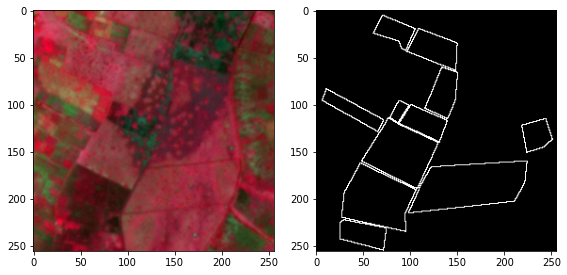

In [ ]:
show_image(field, mask)

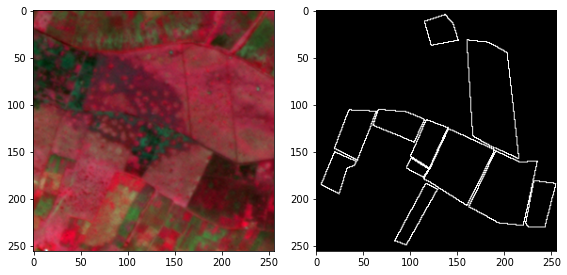

In [ ]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

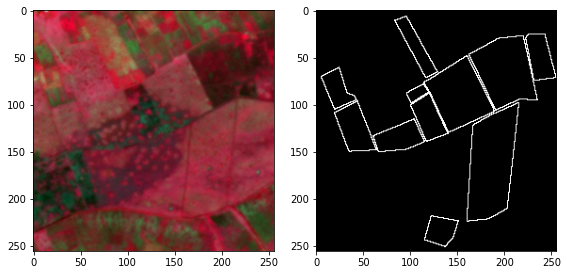

In [ ]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

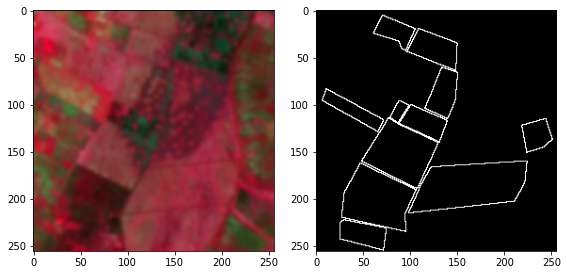

In [ ]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [ ]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
    crop_size: int = None,
    brightness_range: Tuple[float, float] = (0.5, 2),
    contrast_range: Tuple[float, float] = (0.5, 2)
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Random cropping
     - Random brightness
     - Random contrast
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    :param crop_size: Size of the crop to randomly take from the image.
    :param brightness_range: Tuple of two floats representing the range of brightness to apply.
    :param contrast_range: Tuple of two floats representing the range of contrast to apply.
    """
    # Generate transformations
    f, m = [0,1,2,3,4,5,6], [0,1,2,3,4,5,6] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    f[4],m[4] = t_random_cropping(field, mask, crop_size=crop_size) #random cropping
    f[5],m[5] = t_random_brightness(field, mask, brightness_range=brightness_range) #random brightness
    f[6],m[6] = t_random_contrast(field, mask, contrast_range=contrast_range) #random contrast
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
    crop_size: int,
    brightness_range: Tuple[float, float],
    contrast_range: Tuple[float, float],
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Random cropping
     - Random brightness
     - Random contrast
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    :param crop_size: Size of the random crop
    :param brightness_range: Tuple of min and max values for the brightness transformation
    :param contrast_range: Tuple of min and max values for the contrast transformation
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
        crop_size=crop_size,
        brightness_range=brightness_range,
        contrast_range=contrast_range,
    )


In this updated version of the main function, we've added three new parameters for passing in the crop_size, brightness_range, and contrast_range values to the generate function. These parameters will be used to call the corresponding data augmentation functions t_random_cropping, t_random_brightness, and t_random_contrast in the generate function.

In [ ]:
#apply augmentation effects to training set
for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"./augmented_data/{timestamp}"):
        os.makedirs(f"./augmented_data/{timestamp}")
    if not os.path.isdir(f"./augmented_data/{timestamp}/fields"):
        os.makedirs(f"./augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"./augmented_data/{timestamp}/masks"):
        os.makedirs(f"./augmented_data/{timestamp}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = tile_id,
        write_folder = f"./augmented_data/{timestamp}"
    )


In [ ]:
# Get all timestamps
timestamps = next(os.walk(f"./{folder_name}"))[1]

# Get all augmented tile ids. can just use one timestamp
augmented_files = next(os.walk(f"./{folder_name}/{timestamps[0]}/{fields_folder_name}"))[2]

# Initialize the X and y arrays
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene

# Iterate through the augmented files
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for timestamp in timestamps:
        with open(f"./{folder_name}/{timestamp}/{fields_folder_name}/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"./{folder_name}/{timestamp}/{masks_folder_name}/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1


This code is loading the time-series image and mask data from the "augmented_data" folder. It first gets all the timestamps and all the augmented tile ids by using the os.walk() function. Then it initializes two arrays, X and y, which will be used to store the time-series image and mask data respectively.

The code then iterates through the list of augmented files, and for each file it loads the corresponding field data and mask data from the "fields" and "masks" folders respectively. The field data is loaded for each timestamp and is concatenated to form a time-series image. The mask data is loaded for the last timestamp and reshaped to have the same dimensions as the image. Finally, the data is added to the X and y arrays, and the iteration continues until all files have been processed.

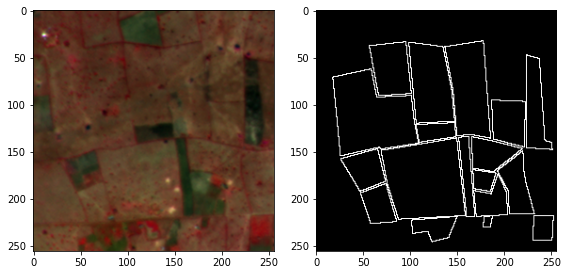

In [ ]:
random.randint(0, len(augmented_files)) #sanity check
random_image = random.randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:3], y[random_image].reshape(IMG_WIDTH, IMG_HEIGHT))

### Model Training

We decided to use U-Net as it has shown impressive results over multiple domains in image segmentation.
We will employ a ResNet34 backbone with our spatio-temporal U-Net model.

This uses our 24 channels (6 timestamps * 4 bands per timestamp) and generates the predicted field boundary per scene.

We will also use an 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary), we will use the `binary cross_entropy` loss.

In [ ]:
# Model Training
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X = preprocess_input(X)

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X = preprocess_input(X)

#https://github.com/sustainlab-group/ParcelDelineation/blob/master/models/unet.py
def unet(pretrained_weights = None,input_size = (256,256,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return 

In [ ]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

In [ ]:
num_channels = 24
input_shape = (256,256,num_channels)
batch_size = 4

For the model, we will make use of two key metrics: **Recall** and **F1-score**.

**Recall** evaluates how much of the field boundaries which were labelled were actually predicted as well while the **f1-score** combines the precision and recall by evaluating the harmonic mean.

**NOTE** that the recall is the more important metric for this case as we are mostly concerned about the retrieved field boundaries out of the labelled field boundaries.

In [ ]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

In [ ]:
sm.set_framework('tf.keras')
sm.framework()
model = None 
model_unet = Unet(BACKBONE, encoder_weights='imagenet')
new_model = keras.models.Sequential()
new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
new_model.add(model_unet)
model = new_model 
#sm.metrics.FScore(beta=1)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler(0)),
              metrics=[recall,f1])

85532672/85521592 [==============================] - 4s 0us/step
Set Learning Rate : 0.0001


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       75        
                                                                 
 model_1 (Functional)        (None, None, None, 1)     24456154  
                                                                 
Total params: 24,456,229
Trainable params: 24,438,879
Non-trainable params: 17,350
_________________________________________________________________


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=200)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
45/45 [==============================] - 20s 221ms/step - loss: 0.5821 - recall: 0.2810 - f1: 0.1032 - val_loss: 2.4219 - val_recall: 0.9676 - val_f1: 0.1195
Epoch 2/200
45/45 [==============================] - 12s 217ms/step - loss: 0.3944 - recall: 0.0202 - f1: 0.0267 - val_loss: 0.7348 - val_recall: 0.6250 - val_f1: 0.1442
Epoch 3/200
45/45 [==============================] - 10s 228ms/step - loss: 0.3077 - recall: 0.0012 - f1: 0.0023 - val_loss: 0.4014 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/200
45/45 [==============================] - 10s 217ms/step - loss: 0.2691 - recall: 9.5471e-04 - f1: 0.0019 - val_loss: 0.3360 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 5/200
45/45 [==============================] - 9s 208ms/step - loss: 0.2464 - recall: 4.0466e-04 - f1: 8.0267e-04 - val_loss: 0.2924 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 6/200
45/45 [==============================] - 9s 206ms/step - loss: 0.2325 - recall: 1.4802e-04 - f1: 2.9475

In [ ]:
model.save(f"./unet_model.h5")

In [ ]:
model = load_model(f"./unet_model.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1})

### Loading test chips to run predictions

In [ ]:
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [ ]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [ ]:
X_test = np.empty((len(test_tile_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in timestamps:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)
        
        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        X_test[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx+=IMG_CHANNELS
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches 
    i+=1

In [ ]:
predictions_dictionary = {}
for i in range(len(test_tile_ids)):
    model_pred = model.predict(np.expand_dims(X_test[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    predictions_dictionary.update([(str(loaded_tiles[i]), pd.DataFrame(model_pred))])

In [ ]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

In [ ]:
sub.to_csv(f"./harvest_sample_submission.csv", index = False)